# Data Analysis


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

In [2]:
# Mount drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Define directory where cleaned data was saved
data_dest =  "/content/drive/My Drive/DS 5100 Food Environment Project/Data_Cleaned/"

In [4]:
# Read in cleaned data
df_county = pd.read_csv(data_dest + 'County_Level_Data.csv')

In [14]:
# Define a class for county level analysis
class countyAnalysis:
  # Decription of class and fields

  def __init__(self, df_county, target_var = None, var_list = None):
    '''
    Class constructor
    df_county: county level dataframe (pre-formatted and cleaned)
    target_var: optional, specify variable of interest for future analysis
    var_list: optional, specific list of variables you're interested in exploring (i.e. their relation to target)
    '''
    self.df_county = df_county.copy() # Original dataframe, copy so that changes within class doesn't change original
    self.target_var = target_var
    self.var_list = var_list

  def select_state(self, state):
    # Filter dataframe to counties from a specfific state
    self.df_county = self.df_county[self.df_county['State']==state]

  def calculate_na_summary(self):
    # Calculate percent missing
    self.pct_missing = self.df_county.isnull().sum() * 100 / len(self.df_county)
    # Find variable with largest % missing
    print('Missing values summary: ')
    print('The 10 variables with the highest percent missing are: ') 
    print(self.pct_missing.nlargest(10))

  def remove_missing_threshold_cols(self, threshold):
    print(f"Removing columns with greater than {(threshold)*100}% missing")
    # Remove variables with more than "theshold"% missing
    # Threshold in drop na is number of observations so multiply theshold % by number of rows
    self.df_county.dropna(thresh=self.df_county.shape[0]*(1-threshold), axis=1, inplace=True)

  def remove_missing_threshold_rows(self, threshold):
    print(f"Removing rows (counties) with greater than {(threshold)*100}% missing")
    # Remove rows (counties) with more than "theshold"% missing
    # Threshold in drop na is number of observations so multiply theshold % by number of columns
    self.df_county.dropna(thresh=self.df_county.shape[1]*(1-threshold), axis=0, inplace=True)

  def calculation_correlations_with_variable(self, num_pos_corr = 10, num_neg_corr = 10, display_all = False):
    '''
    num_pos_corr: number of top postive correlations to display. Default 10
    num_neg_corr: number of top negative correlations to display. Default 10   
    display_all: (default false), but if true will display all correlations (not just top pos/neg)
    '''
    # todo: skip non-numeric columns
    # todo: option to remove high correlations
    
    # If haven't defined variable of interest, prompt user to select
    if self.target_var is None:
      self.select_target_var()
    if self.var_list is not None: # If provided a list of variables only calculte correlations for those
      self.corrs_with_var = self.df_county[self.var_list].apply(lambda x: x.corr(self.df_county[self.target_var]))
    else: # Otherwise use all other variables (but only numeric columns)
      numeric_cols = self.df_county.select_dtypes(include=np.number).columns.tolist() # Select only numeric columns to calculate correlations with target
      self.corrs_with_var = self.df_county[numeric_cols].drop([self.target_var],axis=1).apply(lambda x: x.corr(self.df_county[self.target_var]))
    if not display_all:
      # Display top correlations
      print(f'Top {num_pos_corr} largest (positives) correlations with {self.target_var}: ')
      print(self.corrs_with_var.nlargest(num_pos_corr))
      print(f'Top {num_neg_corr} smallest (negative) correlations {self.target_var}: ')
      print(self.corrs_with_var.nsmallest(num_neg_corr))
    else:
      print(f"Top correlations with {self.target_var}:")
      print(self.corrs_with_var.sort_values())

  def average_metro_vs_nonmetro(self, new_var_list = None):
    '''
    Calculate average value of variables for metro vs non-metro counties
    '''
    if new_var_list is not None: # If provided a variable list for this function use it
        self.averages_metro_nonmetro = self.df_county.groupby(['METRO13'])[new_var_list].mean()
    elif self.var_list is not None: # Otherwise use var_list for the class
      self.averages_metro_nonmetro = self.df_county.groupby(['METRO13'])[self.var_list].mean()
    else: # Otherwise calculate for all variables
      self.averages_metro_nonmetro = self.df_county.groupby(['METRO13']).mean()

  def find_zero_variance_state_cols(self, drop = False):
    # Calculate standard deviation for each variable within each state
    # To identify columns that are really at a state level 
    # (i.e. all counties within the state have the same value)
    state_stdev = self.df_county.groupby(['State']).std()

    self.state_zero_var_cols = []
    for col in state_stdev.columns:
      if state_stdev[col].sum() == 0:
        self.state_zero_var_cols.append(col)

    # If desired, drop columns that are really state level
    if drop == True:
      self.df_county.drop(self.state_zero_var_cols, axis=1, inplace=True)


  def find_most_recent_data(self, drop = False):
    '''
    Some of the columns in this dataset measure the same thing but for different years.
    For example: 'LACCESS_POP10' and 'LACCESS_POP15'.
    For some analysis we may be interested in both of these columns while for others 
    we may only want to consider the most recent year.
    This function helps to find the columns that contain data for multiple years
    and gives the option of dropping any that are not the most recent.
    '''
    column_stub_dict = {}

    # Create dictionary of column name stubs (column name minus last two elements)
    # With list of the last two elements (i.e. years) that match each name stub
    for i, col in enumerate(self.df_county.columns):
      if f'{col[:-2]}' in column_stub_dict: # If we've already searched for columns that match this beginning
        continue # Skip this column
      column_stub_dict[f'{col[:-2]}'] = [col[-2:]] # Create dictionary row for this beginning
      for j, x in enumerate(self.df_county.columns[i+1:]): # Search subsequent columns for match
        if col[:-2] == x[:-2]: # If the elements are the same (other than the last two (years))
          column_stub_dict[f'{col[:-2]}'].append(x[-2:]) # Add the years to the dictionary

    # Use column name stub dictionary to find latest (and oldest) datapoint for each
    self.list_recent_cols = []
    self.list_non_recent_cols = []
    for stub in column_stub_dict:
      if len(column_stub_dict[stub])>1: # if there were more than one column (year) for this stub
        int_year_lst = [int(year) for year in column_stub_dict[stub]] # Create list of ints so we can check for max
        for year in column_stub_dict[stub]: # Loop through each year
          if int(year) == max(int_year_lst): # If it is the max add to list_recent_cols
            self.list_recent_cols.append(f'{stub}{year}')
          else: # Otherwise add to list of non-recent columns
            self.list_non_recent_cols.append(f'{stub}{year}')

    # Keep only the most recent data points (if desired)
    if drop == True:
      self.df_county.drop(self.list_non_recent_cols, axis=1, inplace=True)


  def select_variables_to_analyze(self, n):
    '''
    n: number of variables to select
    '''
    print(f"Randomly selecting {n} variables for analysis...")
    all_vars = [var for var in self.df_county.columns if var not in ["FIPS",	"State",	"County"]]
    self.var_list = random.sample(all_vars, n)
    print(f"Selected variables: {self.var_list}")

  def select_target_var(self):
      print("Please select a variable of interest: ")
      self.target_var = input()
      if self.target_var not in self.df_county.columns:
        print("This variable is not in this dataset.")
        print("Will be using default (LACCESS_POP15) until a valid variable is chosen.")
        self.target_var = "LACCESS_POP15"

  def visualize_relationships(self):
    # If haven't defined list of variable to search, randomly select 10
    if self.var_list is None:
      self.select_variables_to_analyze(10)
    # Create pairplot to visualize distribution and relationships between var_list and target
    sns.pairplot(self.df_county[[self.target_var]+self.var_list])
    



  '''
  Other ideas:
  - return county with largest/smallest value for a specified variable of interest
  - more plotting/visualizing
  - exploring/visualizing across years (2012/2017) - like side by side graphs grace had
  - differences by region (north east vs midwest)
  - categorize state by percent metro vs nonmetro?
  - user input (what variable to look at, state)
  
  Other to do:
  - Build in check for whether or not variables are in columns (for target_var and var_list)....maybe do some fuzzy matching to match user input to variable column
  '''

In [ ]:
# Create instance of county level analysis class
analysis = countyAnalysis(df_county, target_var = "POVRATE15") 

In [ ]:
analysis.calculation_correlations_with_variable(num_pos_corr=10)

Top 10 largest (positives) correlations with POVRATE15: 
CHILDPOVRATE15           0.938094
PC_SNAPBEN12             0.808047
PCT_FREE_LUNCH15         0.807233
PCT_FREE_LUNCH10         0.805589
PC_SNAPBEN17             0.783732
PERCHLDPOV10             0.674762
PERPOV10                 0.646645
PC_WIC_REDEMP11          0.602845
PC_WIC_REDEMP16          0.595456
PCT_DIABETES_ADULTS08    0.561606
dtype: float64
Top 10 smallest (negative) correlations POVRATE15: 
MEDHHINC15            -0.783640
PCT_NHWHITE10         -0.484686
PCT_REDUCED_LUNCH15   -0.335172
RECFACPTH11           -0.277758
FSRPTH16              -0.270858
RECFACPTH16           -0.262709
FSRPTH11              -0.249183
PCH_SNAP_12_17        -0.245638
METRO13               -0.217190
PCT_LACCESS_WHITE15   -0.216494
dtype: float64


In [ ]:
analysis.calculate_na_summary()

Missing values summary: 
The 10 variables with the highest percent missing are: 
FOODHUB18                      94.276630
PCH_GHVEG_SQFTPTH_07_12        89.125596
PCH_GHVEG_SQFT_07_12           89.125596
PCH_FRESHVEG_ACRESPTH_07_12    66.550079
PCH_FRESHVEG_ACRES_07_12       66.550079
PCH_GHVEG_FARMS_07_12          61.812401
PCH_AGRITRSM_RCT_07_12         59.713831
PCH_BERRY_ACRESPTH_07_12       59.523052
PCH_BERRY_ACRES_07_12          59.523052
PCH_PC_WIC_REDEMP_11_16        42.511924
dtype: float64


In [ ]:
analysis.remove_missing_threshold_cols(threshold = 0.3)

Removing columns with greater than 30.0% missing


In [ ]:
analysis.remove_missing_threshold_rows(threshold = 0.3)

Removing rows (counties) with greater than 30.0% missing


In [ ]:
analysis.calculate_na_summary()

Missing values summary: 
The 10 variables with the highest percent missing are: 
PCH_BERRY_FARMS_07_12     28.789809
PCH_VEG_ACRESPTH_07_12    28.503185
GHVEG_SQFTPTH12           28.439490
GHVEG_SQFT12              28.407643
GHVEG_SQFT07              26.751592
GHVEG_SQFTPTH07           26.751592
BERRY_ACRES07             26.592357
BERRY_ACRESPTH07          26.592357
BERRY_ACRESPTH12          25.700637
BERRY_ACRES12             25.668790
dtype: float64


In [ ]:
# Find and keep only the most recent column for matching ones 
# (i.e. keep LACCESS_POP15 and drop LACCESS_POP10)
analysis.find_most_recent_data(drop = True)

In [ ]:
# Find columns that don't vary within a state and drop them
analysis.find_zero_variance_state_cols(drop = True)

In [ ]:
analysis.calculation_correlations_with_variable()

Top 10 largest (positives) correlations with POVRATE15: 
CHILDPOVRATE15           0.938012
PCT_FREE_LUNCH15         0.807233
PC_SNAPBEN17             0.783732
PERCHLDPOV10             0.674879
PERPOV10                 0.646844
PCT_DIABETES_ADULTS13    0.530696
PCT_NHBLACK10            0.517025
SNAPSPTH17               0.465025
PCT_LACCESS_HHNV15       0.452562
PCT_LACCESS_BLACK15      0.395634
dtype: float64
Top 10 smallest (negative) correlations POVRATE15: 
MEDHHINC15            -0.784790
PCT_NHWHITE10         -0.485148
PCT_REDUCED_LUNCH15   -0.335172
FSRPTH16              -0.268829
RECFACPTH16           -0.260482
METRO13               -0.216558
PCT_LACCESS_WHITE15   -0.216494
SPECSPTH16            -0.193622
DIRSALES_FARMS12      -0.184816
PCT_LOCLFARM12        -0.181155
dtype: float64


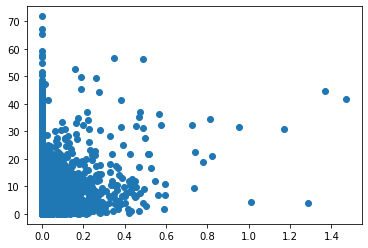

In [ ]:
plt.scatter(analysis.df_county.FMRKTPTH18, analysis.df_county.PCT_LACCESS_LOWI15)

In [ ]:
# Randomly select n variables to analyze with target
analysis.select_variables_to_analyze(n=10)

Randomly selecting 10 variables for analysis...
Selected variables: ['PCH_PC_DIRSALES_07_12', 'PCH_FFR_11_16', 'PCH_FRESHVEG_FARMS_07_12', 'GHVEG_SQFT12', 'FMRKT_SNAP18', 'PCH_GROCPTH_11_16', 'PCT_FREE_LUNCH15', 'WICS16', 'PCH_FFRPTH_11_16', 'ORCHARD_ACRES12']


In [ ]:
# Calcualte correltions between variables randomly selected and target
analysis.calculation_correlations_with_variable(display_all= True)

Top correlations with LACCESS_LOWI15:
PCH_FFRPTH_11_16           -0.008465
PCH_GROCPTH_11_16          -0.004879
PCH_FRESHVEG_FARMS_07_12    0.026497
PCH_FFR_11_16               0.029844
PCT_FREE_LUNCH15            0.029911
PCH_PC_DIRSALES_07_12       0.051685
ORCHARD_ACRES12             0.131843
GHVEG_SQFT12                0.200618
FMRKT_SNAP18                0.433128
WICS16                      0.566010
dtype: float64


In [ ]:
analysis.average_metro_vs_nonmetro(analysis.var_list)
analysis.averages_metro_nonmetro

,PCH_PC_DIRSALES_07_12,PCH_FFR_11_16,PCH_FRESHVEG_FARMS_07_12,GHVEG_SQFT12,FMRKT_SNAP18,PCH_GROCPTH_11_16,PCT_FREE_LUNCH15,WICS16,PCH_FFRPTH_11_16,ORCHARD_ACRES12
METRO13,,,,,,,,,,
0.0,49.074975,6.113612,25.115219,8300.641079,0.316456,-1.359662,48.180914,4.513543,7.225058,721.730971
1.0,56.750192,9.530056,21.009046,45710.774314,1.928755,-3.109285,43.105515,30.956866,6.656098,3970.498534


In [ ]:
analysis.average_metro_vs_nonmetro(['PCT_LACCESS_POP15', 'GROCPTH16', 'PCT_DIABETES_ADULTS13', 'PCT_REDUCED_LUNCH15'])
analysis.averages_metro_nonmetro

,PCT_LACCESS_POP15,GROCPTH16,PCT_DIABETES_ADULTS13,PCT_REDUCED_LUNCH15
METRO13,,,,
0.0,24.389757,0.285513,11.514127,8.022347
1.0,20.852670,0.173189,10.771416,6.069601


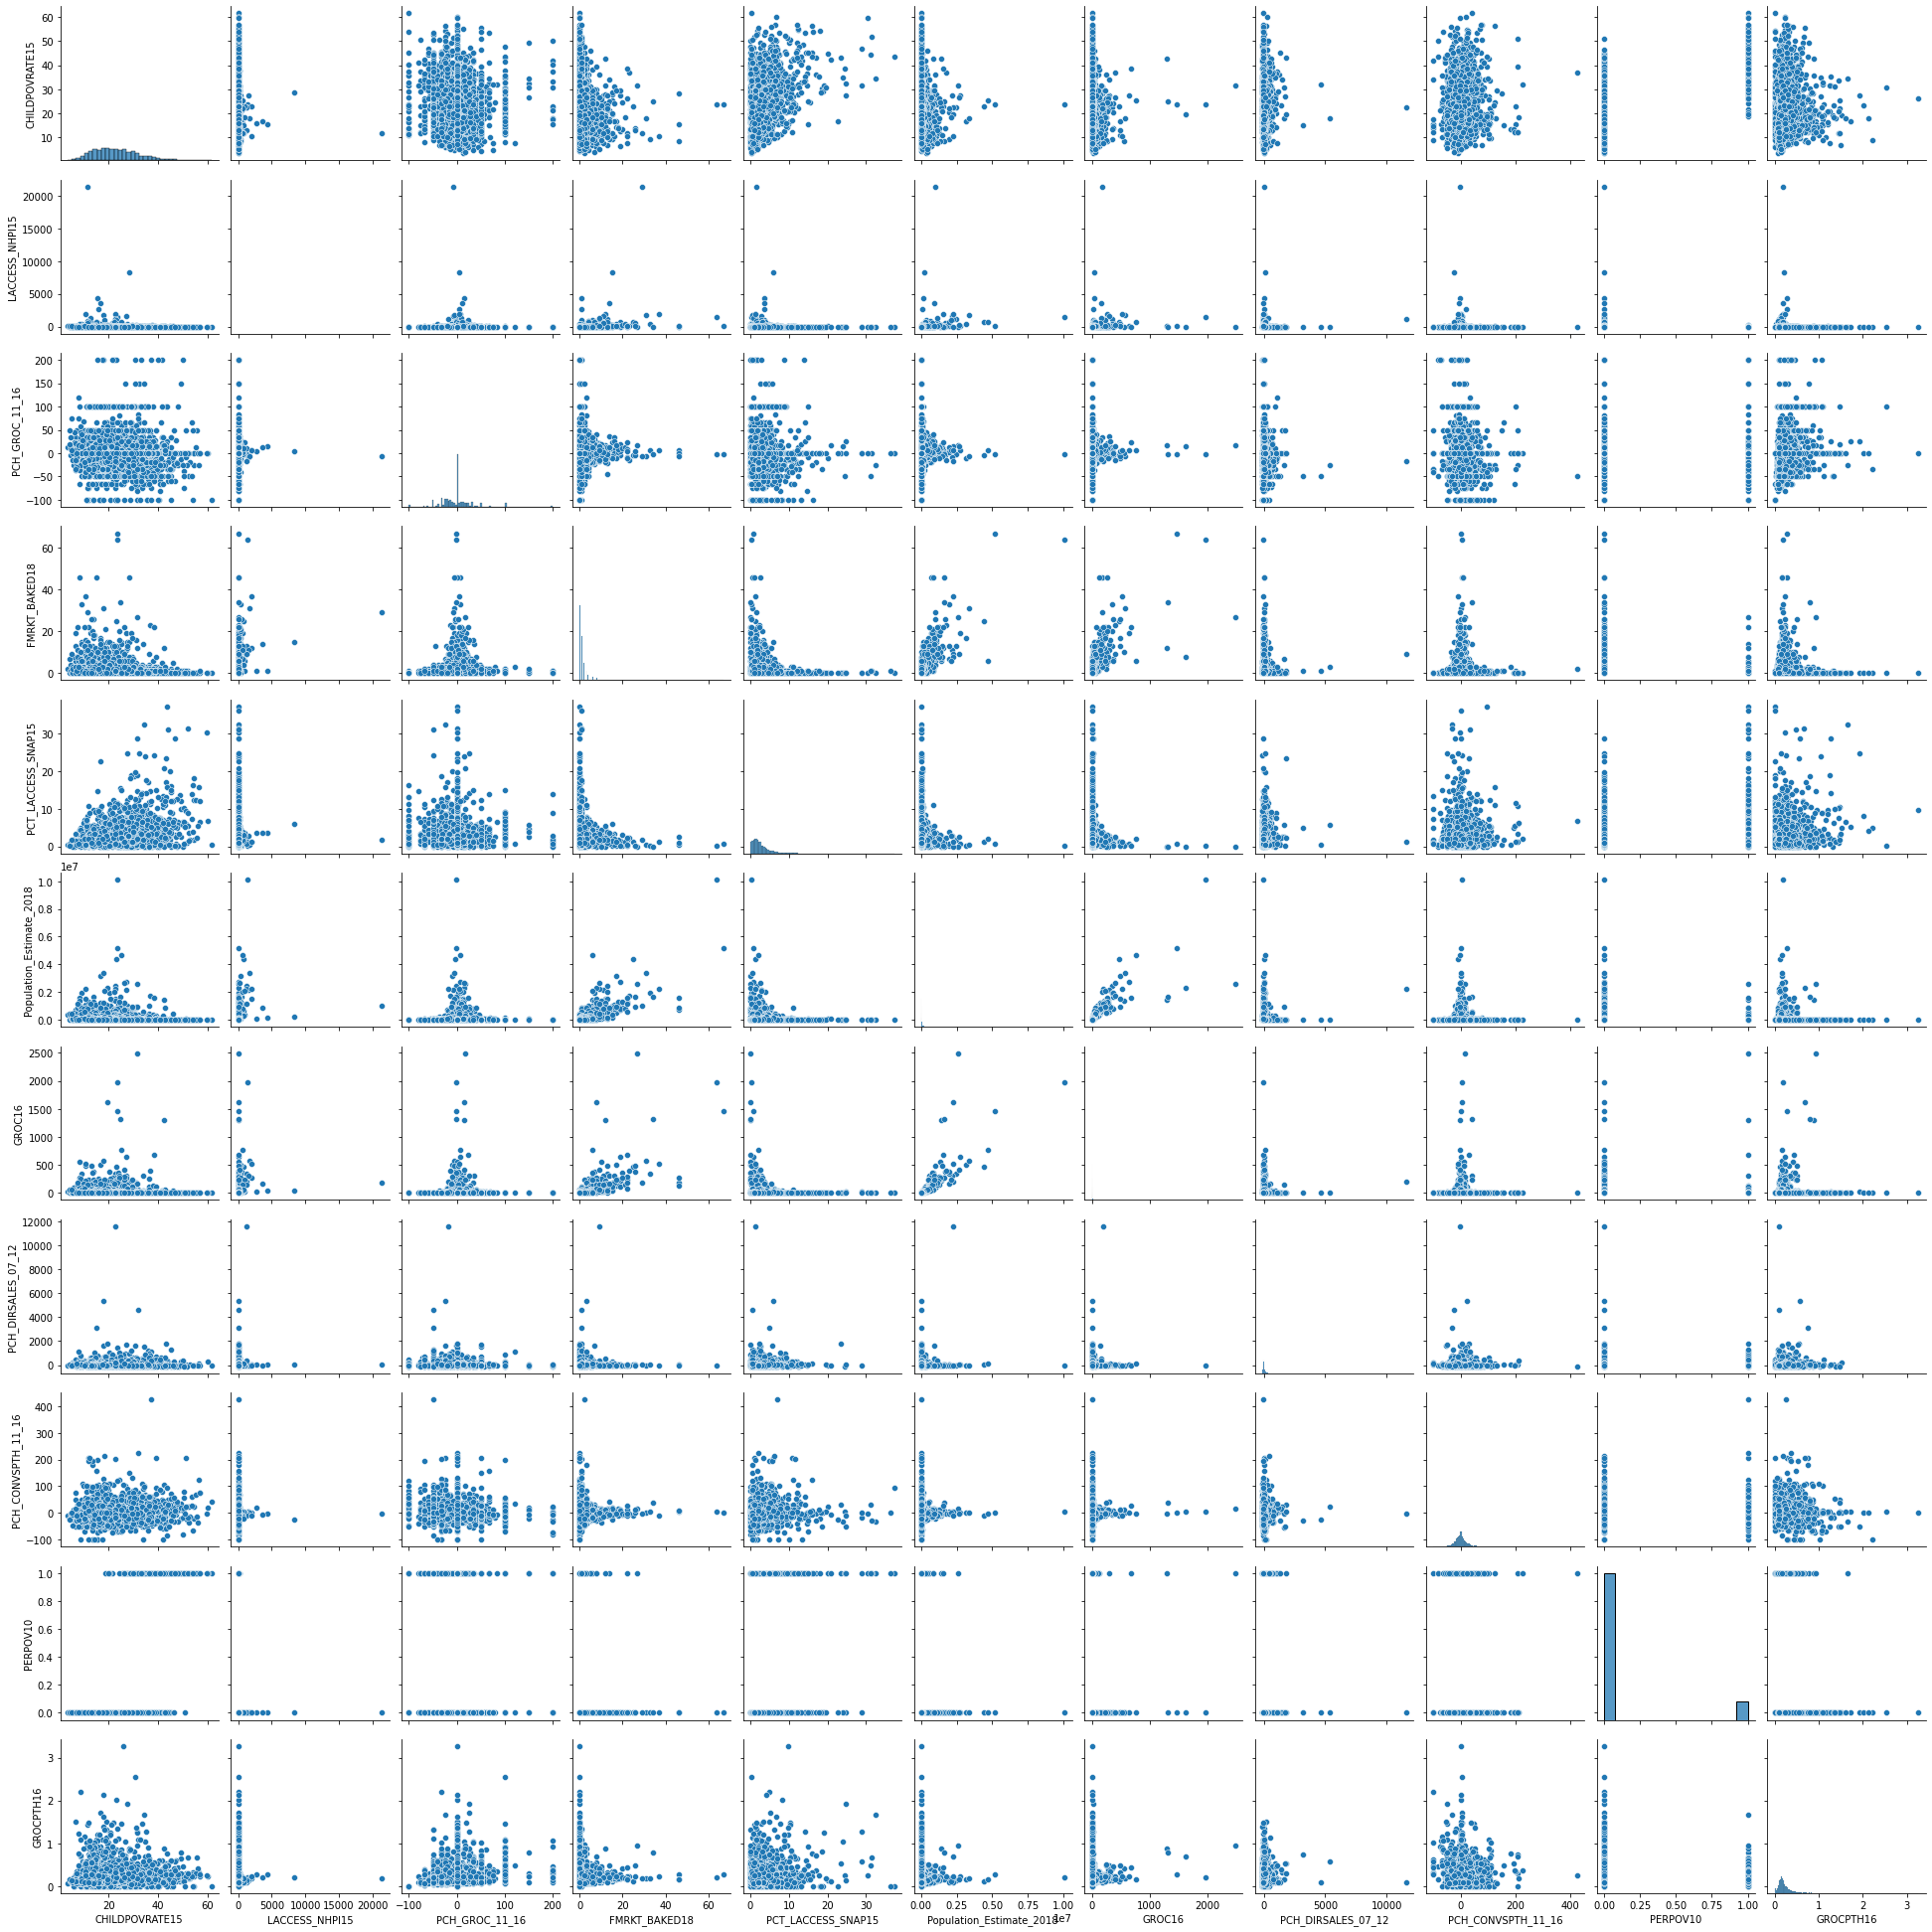

In [ ]:
analysis.visualize_relationships()

In [ ]:
analysis.select_state('MA')

In [ ]:
analysis.df_county

,FIPS,State,County,2010_Census_Population,AGRITRSM_OPS12,BERRY_ACRES12,BERRY_ACRESPTH12,BERRY_FARMS12,CHILDPOVRATE15,CONVS16,CONVSPTH16,CSA12,DIRSALES12,DIRSALES_FARMS12,FARM_TO_SCHOOL15,FDPIR15,FFR16,FFRPTH16,FMRKT18,FMRKTPTH18,FMRKT_ANMLPROD18,FMRKT_BAKED18,FMRKT_CREDIT18,FMRKT_FRVEG18,FMRKT_OTHERFOOD18,FMRKT_SFMNP18,FMRKT_SNAP18,FMRKT_WIC18,FMRKT_WICCASH18,FOOD_BANKS18,FRESHVEG_FARMS12,FSR16,FSRPTH16,GHVEG_FARMS12,GHVEG_SQFT12,GHVEG_SQFTPTH12,GROC16,GROCPTH16,LACCESS_BLACK15,LACCESS_CHILD15,...,PCT_LACCESS_LOWI15,PCT_LACCESS_MULTIR15,PCT_LACCESS_NHASIAN15,PCT_LACCESS_NHNA15,PCT_LACCESS_NHPI15,PCT_LACCESS_POP15,PCT_LACCESS_SENIORS15,PCT_LACCESS_SNAP15,PCT_LACCESS_WHITE15,PCT_LOCLFARM12,PCT_LOCLSALE12,PCT_NHASIAN10,PCT_NHBLACK10,PCT_NHNA10,PCT_NHPI10,PCT_NHWHITE10,PCT_REDUCED_LUNCH15,PC_DIRSALES12,PC_SNAPBEN17,PERCHLDPOV10,PERPOV10,POPLOSS10,POVRATE15,Population_Estimate_2018,RECFAC16,RECFACPTH16,REDEMP_SNAPS17,REDEMP_WICS16,SLHOUSE12,SNAPS17,SNAPSPTH17,SPECS16,SPECSPTH16,SUPERC16,SUPERCPTH16,VEG_ACRES12,VEG_ACRESPTH12,VEG_FARMS12,WICS16,WICSPTH16
1218,25001,MA,Barnstable,215888.0,11.0,1043.0,4.855544,82.0,11.5,135.0,0.632496,11.0,1248.0,81.0,1.0,0.0,218.0,1.021364,19.0,0.089029,15.0,15.0,12.0,15.0,15.0,11.0,12.0,10.0,6.0,0.0,46.0,434.0,2.033358,15.0,61750.0,287.468693,76.0,0.356072,1522.168781,18820.539140,...,9.717726,1.528957,0.465696,0.282208,0.014066,48.379442,11.469996,3.192731,45.383442,24.324324,6.524808,1.048229,1.786575,0.548433,0.030108,91.402486,NaN,5.809894,10.339949,0.0,0.0,0.0,7.6,213413.0,42.0,0.196777,124695.60510,44783.45313,0.0,180.083333,0.843703,51.0,0.238943,1.0,0.004685,138.0,0.386395,46.0,34.0,0.159291
1219,25003,MA,Berkshire,131219.0,24.0,NaN,NaN,49.0,19.6,68.0,0.536032,27.0,1385.0,190.0,1.0,0.0,113.0,0.890760,19.0,0.150378,16.0,15.0,14.0,16.0,16.0,9.0,8.0,7.0,3.0,0.0,85.0,218.0,1.718457,18.0,40260.0,309.285478,35.0,0.275899,632.542127,6037.841623,...,5.971745,0.571331,0.397395,0.026324,0.003733,24.321984,4.731523,2.623480,22.841151,36.190476,6.164323,1.220860,2.540791,0.150131,0.017528,90.631692,NaN,10.639851,17.093781,0.0,0.0,1.0,14.3,126348.0,14.0,0.110360,265519.28800,77983.67969,0.0,92.416667,0.731648,10.0,0.078828,1.0,0.007883,388.0,4.701508,86.0,21.0,0.165216
1220,25005,MA,Bristol,548285.0,35.0,1059.0,1.921929,94.0,17.3,308.0,0.551663,25.0,4479.0,174.0,1.0,0.0,386.0,0.691370,24.0,0.042552,14.0,14.0,17.0,20.0,15.0,15.0,9.0,15.0,6.0,0.0,121.0,445.0,0.797045,41.0,105028.0,190.610317,92.0,0.164782,3123.820075,35765.513250,...,4.502100,0.728326,0.505494,0.041403,0.009422,28.955995,3.940878,2.184273,27.101606,24.267782,11.893887,1.849403,2.870040,0.198619,0.021704,85.602196,NaN,8.128724,17.421572,0.0,0.0,0.0,12.6,564022.0,72.0,0.128960,301907.09680,76237.50781,0.0,483.750000,0.861558,42.0,0.075227,8.0,0.014329,1659.0,3.241326,124.0,92.0,0.164919
1221,25007,MA,Dukes,16535.0,7.0,13.0,0.774363,12.0,13.4,8.0,0.462107,0.0,958.0,25.0,1.0,0.0,23.0,1.328558,3.0,0.172891,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,60.0,3.465804,3.0,NaN,NaN,12.0,0.693161,25.720114,241.313492,...,1.372931,0.629211,0.051552,0.052324,0.024191,7.120600,1.248538,0.137535,6.207773,28.409091,27.441994,0.743877,2.884790,1.058361,0.024191,86.332023,NaN,57.064570,4.444445,0.0,0.0,0.0,8.5,17352.0,7.0,0.404344,92093.65189,39017.30859,0.0,9.250000,0.533911,13.0,0.750924,0.0,0.000000,NaN,NaN,7.0,3.0,0.173250
1222,25009,MA,Essex,743159.0,29.0,100.0,0.132092,52.0,16.6,300.0,0.384304,33.0,5472.0,119.0,1.0,0.0,572.0,0.732739,24.0,0.030355,15.0,16.0,18.0,19.0,18.0,14.0,13.0,15.0,6.0,0.0,84.0,646.0,0.827534,11.0,52030.0,68.727297,185.0,0.236987,3819.441800,52062.124100,...,4.413228,1.182018,0.915813,0.054100,0.005655,29.959103,4.312460,1.926098,27.287571,22.796935,21.746215,3.076596,2.632815,0.123123,0.021664,76.031509,NaN,7.228056,15.457535,0.0,0.0,0.0,11.5,790638.0,123.0,0.157564,245846.32010,81917.56250,1.0,509.333333,0.648663,68.0,0.087109,5.0,0.006405,850.0,1.412060,84.0,141.0,0.180684
1223,25011,MA,Franklin,71372.0,28.0,354.0,4.950634,100.0

Explore state with highest level of food insecurity

In [13]:
# State level variable 
# Household food insecurity (%, three-year average), 2015-17*
# FOODINSEC_15_17
df_state_FOODINSEC_15_17 = df_county.groupby('State')['FOODINSEC_15_17'].mean() # Mean, but same value for all counties in state
df_state_FOODINSEC_15_17.sort_values(ascending=False)

State
NY    17.9
AZ    17.4
LA    17.3
MO    17.2
AL    16.3
OK    15.0
WI    14.9
KY    14.7
NE    14.4
MA    14.4
TX    14.0
OH    13.7
MI    13.6
IA    13.6
NH    13.5
KS    13.3
WY    13.2
AR    13.1
GA    13.0
TN    12.9
OR    12.9
MS    12.8
NC    12.4
RI    12.4
CT    12.2
PA    12.1
FL    11.9
SC    11.7
AK    11.6
MT    11.4
SD    11.4
IN    11.2
CA    11.2
DE    11.2
DC    11.1
IL    11.0
ND    10.9
WA    10.8
UT    10.7
ID    10.5
MD    10.4
ME    10.2
VT    10.1
WV    10.0
VA     9.8
MN     9.5
NJ     9.4
CO     9.2
NV     9.0
NM     8.6
HI     7.4
Name: FOODINSEC_15_17, dtype: float64

In [134]:
df_county.groupby('State')['CH_FOODINSEC_14_17'].mean().sort_values(ascending=False)

State
NY    5.6
PA    0.8
ME    0.6
NV    0.6
VT    0.0
MT   -0.1
RI   -0.3
LA   -0.3
WI   -0.4
NH   -0.4
AK   -0.4
AL   -0.5
IN   -0.5
SD   -0.5
NJ   -0.6
WY   -0.8
ID   -0.9
MN   -0.9
DC   -1.0
IA   -1.0
MI   -1.1
WV   -1.4
OK   -1.5
CT   -1.7
MA   -1.8
FL   -1.9
DE   -2.0
MD   -2.1
SC   -2.2
CA   -2.3
AR   -2.3
NE   -2.3
AZ   -2.5
KS   -2.6
UT   -2.6
GA   -2.7
NC   -2.8
KY   -2.8
VA   -2.8
WA   -2.9
NM   -3.1
IL   -3.1
OH   -3.2
OR   -3.2
TX   -3.2
TN   -3.4
ND   -3.5
MS   -4.0
CO   -4.4
MO   -4.8
HI   -4.9
Name: CH_FOODINSEC_14_17, dtype: float64

New York has the largest rate of Household food insecurity and also had the largest increase 

In [17]:
ny_analysis = countyAnalysis(df_county) 

In [18]:
ny_analysis.select_state('NY')

In [19]:
ny_analysis.remove_missing_threshold_cols(threshold = 0.3)

Removing columns with greater than 30.0% missing


In [20]:
ny_analysis.remove_missing_threshold_rows(threshold = 0.3)

Removing rows (counties) with greater than 30.0% missing


In [21]:
ny_analysis.calculate_na_summary()

Missing values summary: 
The 10 variables with the highest percent missing are: 
FRESHVEG_ACRES12            29.032258
FRESHVEG_ACRESPTH12         29.032258
GHVEG_SQFT12                27.419355
GHVEG_SQFTPTH12             27.419355
PCH_GHVEG_FARMS_07_12       27.419355
AGRITRSM_RCT07              25.806452
PCH_BERRY_ACRESPTH_07_12    16.129032
PCH_BERRY_ACRES_07_12       16.129032
AGRITRSM_RCT12              14.516129
PCH_CSA_07_12               14.516129
dtype: float64


In [22]:
# Find and keep only the most recent column for matching ones 
# (i.e. keep LACCESS_POP15 and drop LACCESS_POP10)
ny_analysis.find_most_recent_data(drop = True)

In [23]:
# Find columns that don't vary within a state and drop them
ny_analysis.find_zero_variance_state_cols(drop = True)

In [47]:
ny_analysis.target_var = 'PCT_DIABETES_ADULTS13'


In [48]:
ny_analysis.calculation_correlations_with_variable()

Top 10 largest (positives) correlations with PCT_DIABETES_ADULTS13: 
CHILDPOVRATE15            0.507342
SNAPSPTH17                0.479750
PCT_FREE_LUNCH15          0.474594
PCH_VEG_ACRESPTH_07_12    0.464768
WICSPTH16                 0.450395
PC_WIC_REDEMP16           0.429153
PCH_SLHOUSE_07_12         0.426387
POVRATE15                 0.368289
PC_SNAPBEN17              0.331369
PERPOV10                  0.310151
dtype: float64
Top 10 smallest (negative) correlations PCT_DIABETES_ADULTS13: 
RECFACPTH16             -0.554978
MEDHHINC15              -0.486162
RECFAC16                -0.385710
FFRPTH16                -0.358336
FMRKT_ANMLPROD18        -0.295289
FSR16                   -0.282789
PCT_LACCESS_NHASIAN15   -0.275836
FMRKT_BAKED18           -0.267900
PCT_LACCESS_HISP15      -0.250676
PCT_LACCESS_MULTIR15    -0.243061
dtype: float64


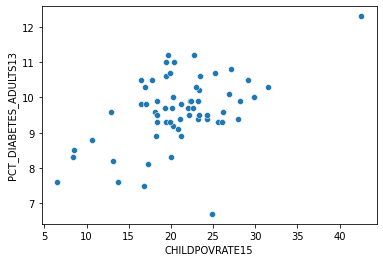

In [49]:
sns.scatterplot(data=ny_analysis.df_county, x='CHILDPOVRATE15', y='PCT_DIABETES_ADULTS13')
# Higher child poverty rates associated with higher diabetes rates

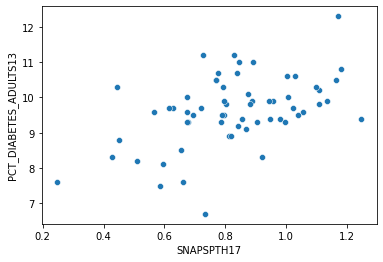

In [57]:
sns.scatterplot(data=ny_analysis.df_county, x='SNAPSPTH17', y='PCT_DIABETES_ADULTS13')
# Counties with more SNAP authorized stores associated with higher diabetes rates 

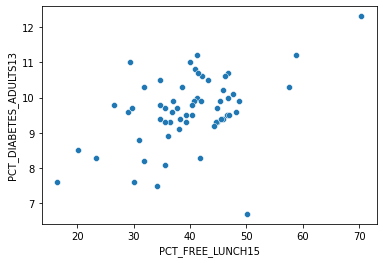

In [60]:
sns.scatterplot(data=ny_analysis.df_county, x='PCT_FREE_LUNCH15', y='PCT_DIABETES_ADULTS13')
# Larger portion of students eligible for free lunch associated with higher diabetes rates

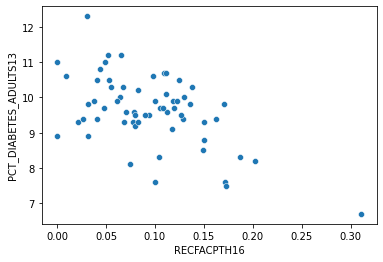

In [115]:
sns.scatterplot(data=ny_analysis.df_county, x='RECFACPTH16', y='PCT_DIABETES_ADULTS13')
# More recreational fitness facilities associated with lower diabetes rates

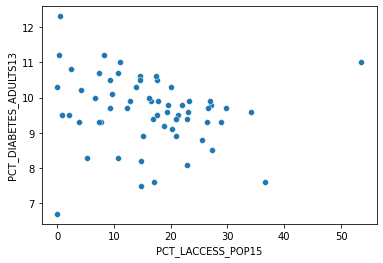

In [167]:
sns.scatterplot(data=ny_analysis.df_county, x='PCT_LACCESS_POP15', y='PCT_DIABETES_ADULTS13')


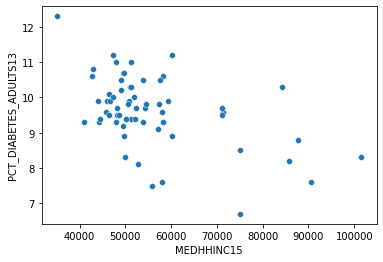

In [116]:
sns.scatterplot(data=ny_analysis.df_county, x='MEDHHINC15', y='PCT_DIABETES_ADULTS13')
# Higher median income associated with lower diabetes rates

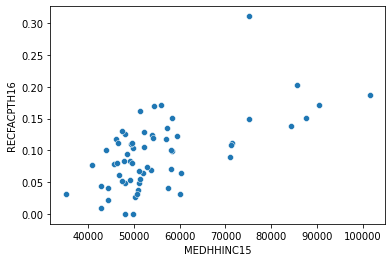

In [117]:
sns.scatterplot(data=ny_analysis.df_county, x='MEDHHINC15', y='RECFACPTH16') 
# Higher median household income correlated with more recreational/fitness facilities

Explore poverty persistent counties versus other counties

In [70]:
pov_persist = countyAnalysis(df_county) 

In [71]:
pov_persist.remove_missing_threshold_cols(threshold = 0.3)

Removing columns with greater than 30.0% missing


In [72]:
pov_persist.remove_missing_threshold_rows(threshold = 0.3)

Removing rows (counties) with greater than 30.0% missing


In [73]:
# Find and keep only the most recent column for matching ones 
# (i.e. keep LACCESS_POP15 and drop LACCESS_POP10)
pov_persist.find_most_recent_data(drop = True)

In [74]:
# Find columns that don't vary within a state and drop them
pov_persist.find_zero_variance_state_cols(drop = True)

In [75]:
pov_persist.df_county.head()

,FIPS,State,County,2010_Census_Population,AGRITRSM_OPS12,BERRY_ACRES12,BERRY_ACRESPTH12,BERRY_FARMS12,CHILDPOVRATE15,CONVS16,CONVSPTH16,CSA12,DIRSALES12,DIRSALES_FARMS12,FARM_TO_SCHOOL15,FDPIR15,FFR16,FFRPTH16,FMRKT18,FMRKTPTH18,FMRKT_ANMLPROD18,FMRKT_BAKED18,FMRKT_CREDIT18,FMRKT_FRVEG18,FMRKT_OTHERFOOD18,FMRKT_SFMNP18,FMRKT_SNAP18,FMRKT_WIC18,FMRKT_WICCASH18,FOOD_BANKS18,FRESHVEG_FARMS12,FSR16,FSRPTH16,GHVEG_FARMS12,GHVEG_SQFT12,GHVEG_SQFTPTH12,GROC16,GROCPTH16,LACCESS_BLACK15,LACCESS_CHILD15,...,PCT_LACCESS_LOWI15,PCT_LACCESS_MULTIR15,PCT_LACCESS_NHASIAN15,PCT_LACCESS_NHNA15,PCT_LACCESS_NHPI15,PCT_LACCESS_POP15,PCT_LACCESS_SENIORS15,PCT_LACCESS_SNAP15,PCT_LACCESS_WHITE15,PCT_LOCLFARM12,PCT_LOCLSALE12,PCT_NHASIAN10,PCT_NHBLACK10,PCT_NHNA10,PCT_NHPI10,PCT_NHWHITE10,PCT_REDUCED_LUNCH15,PC_DIRSALES12,PC_SNAPBEN17,PERCHLDPOV10,PERPOV10,POPLOSS10,POVRATE15,Population_Estimate_2018,RECFAC16,RECFACPTH16,REDEMP_SNAPS17,REDEMP_WICS16,SLHOUSE12,SNAPS17,SNAPSPTH17,SPECS16,SPECSPTH16,SUPERC16,SUPERCPTH16,VEG_ACRES12,VEG_ACRESPTH12,VEG_FARMS12,WICS16,WICSPTH16
0,1001,AL,Autauga,54571.0,10.0,5.0,0.090621,5.0,18.8,31.0,0.560802,3.0,308.0,51.0,0.0,0.0,44.0,0.795977,1.0,0.017985,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,43.0,31.0,0.560802,0.0,0.0,0.000000,3.0,0.054271,4216.473194,4616.971480,...,11.991125,0.884808,0.159000,0.112092,0.016159,32.062255,3.996279,4.608749,23.163613,13.110540,1.554692,0.855766,17.582599,0.397647,0.040314,77.246156,NaN,5.582238,16.354677,0.0,0.0,0.0,12.7,55601.0,6.0,0.108542,223185.6784,161530.29690,0.0,44.666667,0.804747,1.0,0.018090,1.0,0.018090,1230.0,17.181695,45.0,5.0,0.090511
1,1003,AL,Baldwin,182265.0,16.0,93.0,0.488456,41.0,19.6,118.0,0.568650,7.0,648.0,103.0,1.0,0.0,156.0,0.751775,4.0,0.018347,4.0,3.0,2.0,3.0,3.0,4.0,0.0,0.0,0.0,0.0,50.0,236.0,1.137300,4.0,62160.0,326.477447,29.0,0.139753,3540.965826,7007.972675,...,5.424427,0.618712,0.116833,0.099662,0.008131,16.767489,3.061840,1.298900,13.981393,10.414560,0.478010,0.735193,9.308425,0.628755,0.043343,83.504787,6.346384,3.403433,11.479360,0.0,0.0,0.0,12.9,218022.0,21.0,0.101200,157623.1336,102920.08590,1.0,189.416667,0.890836,27.0,0.130115,7.0,0.033733,1958.0,11.975041,50.0,28.0,0.134802
2,1005,AL,Barbour,27457.0,32.0,42.0,1.546449,5.0,45.2,19.0,0.737177,0.0,13.0,13.0,0.0,0.0,23.0,0.892372,4.0,0.160765,0.0,2.0,2.0,2.0,2.0,2.0,2.0,0.0,0.0,0.0,7.0,14.0,0.543183,0.0,0.0,0.000000,4.0,0.155195,2713.124930,1031.927776,...,10.739667,1.684025,0.062266,0.145539,0.029436,22.105560,3.001695,4.303147,10.302934,2.276708,0.012457,0.389700,46.691190,0.218524,0.087409,46.753105,2.317528,0.478663,29.122147,1.0,1.0,0.0,32.0,24881.0,0.0,0.000000,257032.0789,103414.92190,0.0,36.000000,1.424614,2.0,0.077598,1.0,0.038799,41.0,1.178247,7.0,6.0,0.232387
3,1007,AL,Bibb,22915.0,6.0,NaN,NaN,2.0,29.3,15.0,0.662749,3.0,20.0,13.0,0.0,0.0,7.0,0.309283,1.0,0.044643,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,7.0,0.309283,2.0,NaN,NaN,5.0,0.220916,419.099942,232.642670,...,2.601627,0.022951,0.008703,0.010967,0.000000,4.230324,0.600865,0.676710,2.358770,6.878307,NaN,0.096007,21.924504,0.279293,0.030548,75.020729,9.060807,0.883314,17.557791,1.0,0.0,0.0,22.2,22400.0,1.0,0.044183,227725.2451,99703.79688,0.0,18.166667,0.801423,0.0,0.000000,1.0,0.044183,14.0,2.870771,11.0,5.0,0.221474
4,1009,AL,Blount,57322.0,8.0,38.0,0.657713,25.0,22.2,27.0,0.469059,4.0,495.0,88.0,0.0,0.0,23.0,0.399569,1.0,0.017289,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,59.0,12.0,0.208471,0.0,0.0,0.000000,5.0,0.086863,95.842687,910.686113,...,2.880150,0.353990,0.014705,0.050484,0.001854,6.497380,0.882583,0.812727,5.909147,7.091056,0.277792,0.200621,1.263040,0.497191,0.031402,88.887338,7.895581,8.567571,12.377973,0.0,0.0,0.0,14.7,57840.0,4.0,0.069490,142860.8256,99651.75781,0.0,40.166667,0.692374,0.0,0.000000,1.0,0.017373,677.0,10.125312,64.0,8.0,0.139089


In [121]:
pov_persist.df_county.PERPOV10.value_counts(normalize=True)
# About 11% of counties are classified as poverty-persistent

0.0    0.887898
1.0    0.112102
Name: PERPOV10, dtype: float64

In [123]:
# Check distribution by state
pov_persist.df_county.groupby(['State'])['PERPOV10'].mean().sort_values(ascending=False)
# Looks to be clear differences by region

State
MS    0.609756
LA    0.406250
KY    0.333333
GA    0.301887
AL    0.283582
NM    0.272727
SC    0.260870
AR    0.226667
SD    0.166667
OK    0.155844
TX    0.145669
WV    0.145455
AZ    0.133333
MO    0.121739
NC    0.100000
TN    0.094737
MT    0.071429
FL    0.059701
ND    0.056604
CO    0.046875
MD    0.041667
AK    0.035714
UT    0.034483
NY    0.032258
IL    0.029412
ID    0.022727
VA    0.015152
PA    0.014925
OH    0.011364
NE    0.010753
ME    0.000000
NV    0.000000
WI    0.000000
WA    0.000000
VT    0.000000
CA    0.000000
NJ    0.000000
CT    0.000000
DC    0.000000
DE    0.000000
RI    0.000000
MA    0.000000
HI    0.000000
IA    0.000000
MN    0.000000
NH    0.000000
IN    0.000000
KS    0.000000
MI    0.000000
OR    0.000000
WY    0.000000
Name: PERPOV10, dtype: float64

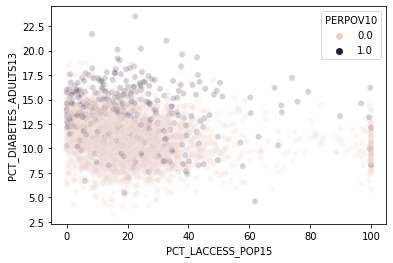

In [169]:
sns.scatterplot(data=df_county, x='PCT_LACCESS_POP15', y='PCT_DIABETES_ADULTS13', hue='PERPOV10', alpha=0.2)


In [114]:
# Caclulate averages of columns of interest for persistent poverty vs other counties
# Demographic columns
cols = ['POVRATE15', 'METRO13', 'PCT_NHWHITE10', 'PCT_NHBLACK10', 'PCT_HISP10', 'PCT_NHASIAN10', 'PCT_65OLDER10', 'PCT_18YOUNGER10']
df_grpd = pov_persist.df_county.groupby('PERPOV10')[cols].mean()
df_grpd
# Nearly double the poverty rate, More non-metro, lower percentage of whites, higher black and hispanic, lower asian, slightly younger population

,POVRATE15,METRO13,PCT_NHWHITE10,PCT_NHBLACK10,PCT_HISP10,PCT_NHASIAN10,PCT_65OLDER10,PCT_18YOUNGER10
PERPOV10,,,,,,,,
0.0,14.787155,0.399211,81.256254,6.496539,7.923872,1.213747,16.045552,23.273823
1.0,28.000000,0.147727,55.074781,26.591961,11.172139,0.507411,14.620551,24.524895


In [108]:
# Health columns
cols = ['PCT_DIABETES_ADULTS13', 'RECFACPTH16']
df_grpd = pov_persist.df_county.groupby('PERPOV10')[cols].mean()
df_grpd
# Higher diabetes rates, fewer recreational facilities per 1000

,PCT_DIABETES_ADULTS13,RECFACPTH16
PERPOV10,,
0.0,10.921915,0.074336
1.0,13.746591,0.037288


In [126]:
# Caclulate averages of columns of interest for persistent poverty vs other counties
# Food access
cols = ['PCT_LACCESS_HHNV15', 'PCT_LACCESS_LOWI15']
df_grpd = pov_persist.df_county.groupby('PERPOV10')[cols].mean()
df_grpd

,PCT_LACCESS_HHNV15,PCT_LACCESS_LOWI15
PERPOV10,,
0.0,2.902777,8.211667
1.0,6.186150,12.037974


In [92]:
# Caclulate averages of columns of interest for persistent poverty vs other counties
# Here look at store avaliability columns
cols = ['GROCPTH16', 'CONVSPTH16', 'FFRPTH16', 'FSRPTH16']
df_grpd = pov_persist.df_county.groupby('PERPOV10')[cols].mean()
df_grpd
# Similar grocery store avaliability, but higher convenience stores, similar or a bit lower for fast food, and much lower for full service restauants

,GROCPTH16,CONVSPTH16,FFRPTH16,FSRPTH16
PERPOV10,,,,
0.0,0.245357,0.576895,0.591918,0.815488
1.0,0.231812,0.746521,0.527250,0.457279


In [104]:
# Caclulate averages of columns of interest for persistent poverty vs other counties
# Here look at local/fresh food access
cols = ['PC_DIRSALES12', 'FMRKTPTH18', 'VEG_ACRESPTH12']
df_grpd = pov_persist.df_county.groupby('PERPOV10')[cols].mean()
df_grpd
# Lower direct farm sales per capita, fewer farmers markets, but larger Vegetable acres harvested/1,000 pop

,PC_DIRSALES12,FMRKTPTH18,VEG_ACRESPTH12
PERPOV10,,,
0.0,8.769686,0.061763,39.744231
1.0,4.194067,0.040473,61.074872


In [148]:
df_county.head()

,FIPS,State,County,2010_Census_Population,AGRITRSM_OPS07,AGRITRSM_OPS12,AGRITRSM_RCT07,AGRITRSM_RCT12,BERRY_ACRES07,BERRY_ACRES12,BERRY_ACRESPTH07,BERRY_ACRESPTH12,BERRY_FARMS07,BERRY_FARMS12,CHILDPOVRATE15,CHIPSTAX_STORES14,CHIPSTAX_VENDM14,CH_FOODINSEC_14_17,CH_VLFOODSEC_14_17,CONVS11,CONVS16,CONVSPTH11,CONVSPTH16,CSA07,CSA12,DIRSALES07,DIRSALES12,DIRSALES_FARMS07,DIRSALES_FARMS12,FARM_TO_SCHOOL13,FARM_TO_SCHOOL15,FDPIR12,FDPIR15,FFR11,FFR16,FFRPTH11,FFRPTH16,FMRKT13,FMRKT18,FMRKTPTH13,...,REDEMP_WICS11,REDEMP_WICS16,SLHOUSE07,SLHOUSE12,SNAPS12,SNAPS17,SNAPSPTH12,SNAPSPTH17,SNAP_BBCE09,SNAP_BBCE16,SNAP_CAP09,SNAP_CAP16,SNAP_OAPP09,SNAP_OAPP16,SNAP_PART_RATE11,SNAP_PART_RATE16,SNAP_REPORTSIMPLE09,SNAP_REPORTSIMPLE16,SODATAX_STORES14,SODATAX_VENDM14,SPECS11,SPECS16,SPECSPTH11,SPECSPTH16,SUPERC11,SUPERC16,SUPERCPTH11,SUPERCPTH16,VEG_ACRES07,VEG_ACRES12,VEG_ACRESPTH07,VEG_ACRESPTH12,VEG_FARMS07,VEG_FARMS12,VLFOODSEC_12_14,VLFOODSEC_15_17,WICS11,WICS16,WICSPTH11,WICSPTH16
0,1001,AL,Autauga,54571.0,7.0,10.0,228000.0,146000.0,NaN,5.0,NaN,0.090621,3.0,5.0,18.8,4.0,4.0,-0.5,-0.1,31.0,31.0,0.561604,0.560802,2.0,3.0,100.0,308.0,25.0,51.0,NaN,0.0,0.0,0.0,34.0,44.0,0.615953,0.795977,1.0,1.0,0.018277,...,172391.75000,161530.29690,0.0,0.0,37.416667,44.666667,0.674004,0.804747,0.0,1.0,0.0,0.0,0.0,1.0,84.02,86.898,1.0,1.0,4.0,4.0,1.0,1.0,0.018116,0.018090,1.0,1.0,0.018116,0.018090,948.0,1230.0,18.089877,17.181695,34.0,45.0,7.2,7.1,5.0,5.0,0.090567,0.090511
1,1003,AL,Baldwin,182265.0,18.0,16.0,124000.0,204000.0,79.0,93.0,0.458226,0.488456,36.0,41.0,19.6,4.0,4.0,-0.5,-0.1,107.0,118.0,0.573622,0.568650,13.0,7.0,715.0,648.0,80.0,103.0,0.0,1.0,0.0,0.0,121.0,156.0,0.648675,0.751775,4.0,4.0,0.020525,...,122739.71090,102920.08590,1.0,1.0,138.333333,189.416667,0.725055,0.890836,0.0,1.0,0.0,0.0,0.0,1.0,84.02,86.898,1.0,1.0,4.0,4.0,20.0,27.0,0.107219,0.130115,6.0,7.0,0.032166,0.033733,2280.0,1958.0,13.224751,11.975041,51.0,50.0,7.2,7.1,26.0,28.0,0.139380,0.134802
2,1005,AL,Barbour,27457.0,27.0,32.0,163000.0,304000.0,NaN,42.0,NaN,1.546449,3.0,5.0,45.2,4.0,4.0,-0.5,-0.1,22.0,19.0,0.804358,0.737177,1.0,0.0,11.0,13.0,18.0,13.0,1.0,0.0,0.0,0.0,19.0,23.0,0.694673,0.892372,3.0,4.0,0.111342,...,85699.46875,103414.92190,0.0,0.0,34.833333,36.000000,1.280590,1.424614,0.0,1.0,0.0,0.0,0.0,1.0,84.02,86.898,1.0,1.0,4.0,4.0,3.0,2.0,0.109685,0.077598,0.0,1.0,0.000000,0.038799,32.0,41.0,1.152862,1.178247,11.0,7.0,7.2,7.1,7.0,6.0,0.255942,0.232387
3,1007,AL,Bibb,22915.0,5.0,6.0,NaN,21000.0,6.0,NaN,0.267404,NaN,6.0,2.0,29.3,4.0,4.0,-0.5,-0.1,19.0,15.0,0.835348,0.662749,2.0,3.0,46.0,20.0,12.0,13.0,0.0,0.0,0.0,0.0,6.0,7.0,0.263794,0.309283,1.0,1.0,0.044413,...,81445.39844,99703.79688,0.0,0.0,16.250000,18.166667,0.719122,0.801423,0.0,1.0,0.0,0.0,0.0,1.0,84.02,86.898,1.0,1.0,4.0,4.0,0.0,0.0,0.000000,0.000000,1.0,1.0,0.043966,0.044183,65.0,14.0,2.896871,2.870771,10.0,11.0,7.2,7.1,6.0,5.0,0.263771,0.221474
4,1009,AL,Blount,57322.0,10.0,8.0,293000.0,30000.0,28.0,38.0,0.497866,0.657713,14.0,25.0,22.2,4.0,4.0,-0.5,-0.1,30.0,27.0,0.521177,0.469059,7.0,4.0,429.0,495.0,84.0,88.0,1.0,0.0,0.0,0.0,20.0,23.0,0.347451,0.399569,1.0,1.0,0.017358,...,123098.56250,99651.75781,0.0,0.0,38.000000,40.166667,0.657144,0.692374,0.0,1.0,0.0,0.0,0.0,1.0,84.02,86.898,1.0,1.0,4.0,4.0,1.0,0.0,0.017373,0.000000,1.0,1.0,0.017373,0.017373,585.0,677.0,10.401849,10.125312,67.0,64.0,7.2,7.1,8.0,8.0,0.139000,0.139089


In [158]:
df_county['Metro'] = np.where(df_county['METRO13']==0, "Non-metro", "Metro")

Text(0.5, 1.0, 'Populations versus Food Access')

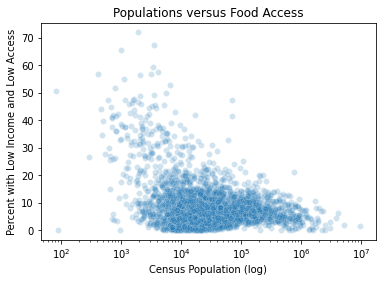

In [163]:
ax = sns.scatterplot(data=df_county, x='2010_Census_Population', y='PCT_LACCESS_LOWI15', alpha = 0.2)
ax.set(xscale='log')
plt.xlabel("Census Population (log)")
plt.ylabel("Percent with Low Income and Low Access")
plt.title("Populations versus Food Access")
# Counties with lower populations tend to have higher percent with low income and low access (i.e. food deserts)

Text(0.5, 1.0, 'Populations versus Food Access by Metro')

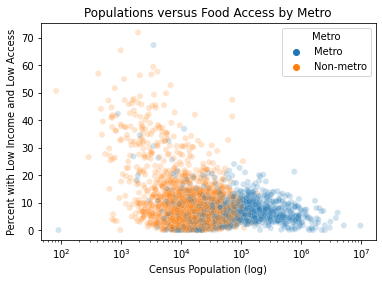

In [162]:
ax = sns.scatterplot(data=df_county, x='2010_Census_Population', y='PCT_LACCESS_LOWI15', hue='Metro', alpha = 0.2)
ax.set(xscale='log')
plt.xlabel("Census Population (log)")
plt.ylabel("Percent with Low Income and Low Access")
plt.title("Populations versus Food Access by Metro")
# Low population and food deserts tend to be in non-metro ares

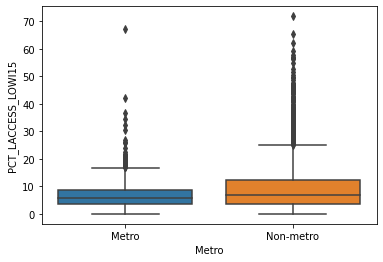

In [165]:
sns.boxplot(data=df_county,x="Metro",y="PCT_LACCESS_LOWI15")
# Confirms analysis before that non-metro more likely to be food deserts

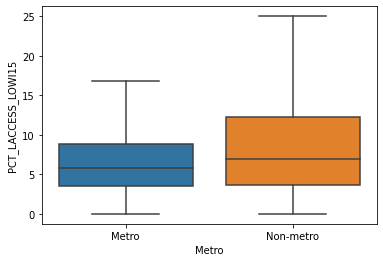

In [166]:
sns.boxplot(data=df_county,x="Metro",y="PCT_LACCESS_LOWI15",showfliers=False)
# this version removes outliers to more clearly see the difference

To do: by region